In [4]:
from collections import defaultdict
from wmdecompose.documents import Document
from wmdecompose.gale_shapeley import Matcher
from wmdecompose.models import LC_RWMD, WMD, WMDPairs
from wmdecompose.utils import *

from gensim.models import KeyedVectors
from nltk.corpus import stopwords
from nltk.tokenize import ToktokTokenizer
from random import shuffle
from scipy.spatial.distance import is_valid_dm, cdist
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn import cluster

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import re
import seaborn as sns
import umap

%load_ext autoreload
%autoreload 2

random.seed(42)

## 1. Prepare IMDB data

### 1.1 Load data and stopwords.

In [5]:
%%time

PATH = "../data/yelp_dataset/"
yelp_data = []
r_dtypes = {"review_id":str,
            "user_id":str,
            "business_id":str,
            "stars": np.int32, 
            "date":str,
            "text":str,
            "useful": np.int32, 
            "funny": np.int32,
            "cool": np.int32}
drop = ['review_id', 'user_id', 'useful', 'funny', 'cool']
query = "date >= '2017-12-01' and (stars==1 or stars ==5)"

with open(f"{PATH}yelp_academic_dataset_review.json", "r") as f:
    reader = pd.read_json(f, orient="records", lines=True, dtype=r_dtypes, chunksize=1000)
    for chunk in reader:
        reduced_chunk = chunk.drop(columns=drop).query(query)
        yelp_data.append(reduced_chunk)
    
yelp_data = pd.concat(yelp_data, ignore_index=True)


CPU times: user 2min 37s, sys: 9.94 s, total: 2min 47s
Wall time: 2min 50s


In [6]:
yelp_data.shape

(1948607, 4)

In [7]:
yelp_business = pd.read_json(f"{PATH}yelp_academic_dataset_business.json", orient="records", lines=True)
yelp_business.shape

(160585, 14)

In [8]:
yelp_business = yelp_business[yelp_business.city.isin(["Portland", "Atlanta"])]
yelp_business.shape

(30815, 14)

In [9]:
yelp_merged = yelp_data.merge(yelp_business, on='business_id')

In [10]:
yelp_merged.shape

(451826, 17)

In [11]:
yelp_merged = yelp_merged.rename(columns={"stars_x":"stars"})

In [12]:
categories = [c.split(",") for c in yelp_merged.categories if c is not None]

In [13]:
c_count = Counter(c.strip() for c_list in categories for c in set(c_list))
c_count.most_common()[:30]

[('Restaurants', 272644),
 ('Food', 125420),
 ('Nightlife', 97019),
 ('Bars', 92658),
 ('Breakfast & Brunch', 55588),
 ('American (New)', 51193),
 ('American (Traditional)', 45802),
 ('Shopping', 40107),
 ('Coffee & Tea', 35901),
 ('Event Planning & Services', 35797),
 ('Sandwiches', 35124),
 ('Beauty & Spas', 34342),
 ('Home Services', 27398),
 ('Cocktail Bars', 27397),
 ('Southern', 25006),
 ('Seafood', 22942),
 ('Health & Medical', 21841),
 ('Mexican', 21828),
 ('Burgers', 21287),
 ('Pizza', 19637),
 ('Desserts', 19446),
 ('Bakeries', 18827),
 ('Local Services', 18501),
 ('Vegan', 17800),
 ('Vegetarian', 17096),
 ('Hotels & Travel', 16855),
 ('Automotive', 16844),
 ('Asian Fusion', 16781),
 ('Salad', 16769),
 ('Beer', 16370)]

In [14]:
yelp_categorized = yelp_merged.assign(categories=yelp_merged['categories'].str.split(',')).explode('categories')
yelp_categorized.categories = yelp_categorized.categories.str.strip()
yelp_categorized.shape

(2424116, 17)

In [15]:
yelp_filtered = yelp_categorized[yelp_categorized.categories.isin(['Restaurants','Health & Medical'])]
yelp_filtered.shape

(294485, 17)

In [16]:
s_size = 1000
rs = 42
sample = yelp_filtered.groupby(["stars", "categories"]).sample(n=s_size, random_state=rs).reset_index()
sample.shape

(4000, 18)

In [17]:
stopword_list=stopwords.words('english')

### 1.2 Remove special formatting and stopwords

In [18]:
tokenizer = ToktokTokenizer()

Remove stopwords before denoising, lemmatizing and removing special characters.

In [19]:
%%time 

sample['review_clean']= [remove_stopwords(r, stopword_list, tokenizer) for r in sample['text']]

CPU times: user 1.53 s, sys: 10.9 ms, total: 1.54 s
Wall time: 1.55 s


Denoise, remove special characters, lemmatize.

In [20]:
%%time

sample['review_clean']=sample['review_clean'].apply(denoise_text)
sample['review_clean']=sample['review_clean'].apply(remove_special_characters)
sample['review_clean']=sample['review_clean'].apply(simple_lemmatizer)

CPU times: user 2.65 s, sys: 74.7 ms, total: 2.73 s
Wall time: 2.76 s


Remove stopwords again, after other preprocessing.

In [21]:
%%time 

sample['review_clean']= [remove_stopwords(r, stopword_list, tokenizer) for r in sample['review_clean']]

CPU times: user 888 ms, sys: 5.44 ms, total: 894 ms
Wall time: 902 ms


Find phrases.

In [22]:
PHRASING = True
MIN = 500
THRESHOLD = 200

In [23]:
%%time

if PHRASING:
    sample['review_clean']= get_phrases([tokenizer.tokenize(i) for i in sample['review_clean']],
                                        min_count = MIN, 
                                        threshold = THRESHOLD,
                                        save=False,
                                        load=True,
                                        PATH="../embeddings/")

Finding bigrams in data.
Finding trigrams in data.
CPU times: user 17.9 s, sys: 4.69 s, total: 22.6 s
Wall time: 23.3 s


Data _before_ preprocessing and phrasing.

In [24]:
sample['text'][6]

"Very poor business practices and patient relations. Some doctors and offices treat you like a human and make you feel good about being a patient. This is not one of them. If you want a relationship with your doctor, a good experience, returned phone calls and professionalism, don't go here. Looks like I'm another reviewer heading to the GA Board of Dentistry......"

Data _after_ preprocessing and phrasing.

In [25]:
#sample['review_clean'][0]
" ".join(sample['review_clean'][6])

'poor business_practice patient relation doctor_office treat like human make feel good patient one want relationship doctor good experience returned phone_call professionalism go look like another_reviewer heading ga board_dentistry'

In [26]:
sample["sentiment"] = ['positive' if s == 5 else 'negative' for s in sample['stars']]

In [27]:
sample[["sentiment", "stars"]]

,sentiment,stars
0,negative,1
1,negative,1
2,negative,1
3,negative,1
4,negative,1
...,...,...
3995,positive,5
3996,positive,5
3997,positive,5
3998,positive,5


In [28]:
sample.head()

,index,business_id,stars,text,date,name,address,city,state,postal_code,latitude,longitude,stars_y,review_count,is_open,attributes,categories,hours,review_clean,sentiment
0,127548,yfYIxgJcjamxnztuDhitUg,1,"this place is a disaster, and I hate My doctor...",2019-04-25 14:34:31,Atlanta Center for Reproductive Medicine,"5909 Peachtree Dunwoody Rd, Ste 600",Atlanta,GA,30328,33.917085,-84.349500,2.5,86,1,"{'ByAppointmentOnly': 'True', 'BusinessAccepts...",Health & Medical,"{'Monday': '8:0-16:0', 'Tuesday': '8:0-16:0', ...","[place, disaster, hate, doctor, carpenter, nur...",negative
1,77717,Mpzv9m1f9qzl5UUHZyTemw,1,I've come here many times. It's hit or miss. T...,2019-12-02 03:38:21,Fly Dragon Spa,1928 NE 42nd Ave,Portland,OR,97213,45.536932,-122.619541,3.5,118,1,"{'BusinessParking': '{'garage': False, 'street...",Health & Medical,"{'Monday': '10:0-23:0', 'Tuesday': '10:0-23:0'...","[come, many, time, hit_miss, evening, male_mas...",negative
2,289181,Hb9O0Ox97v1uxCt77sLoMQ,1,DO NOT GO HERE UNLESS YOU WANT TO BE RIPPED OF...,2018-03-07 22:43:01,Zama Massage,2149 NE Broadway St,Portland,OR,97232,45.535209,-122.643698,4.5,468,1,"{'ByAppointmentOnly': 'False', 'BikeParking': ...",Health & Medical,"{'Monday': '9:0-21:0', 'Tuesday': '9:0-21:0', ...","[go, unless, want, ripped, lied, immensely, di...",negative
3,127843,vOj3VF7l-aUPSHBmasgHPQ,1,uh. this place is definitely closed. boarded u...,2020-01-06 15:15:40,"Joseph Allen, DDS - JBM Dent",1336 Glenwood Ave SE,Atlanta,GA,30316,33.740468,-84.343748,4.5,6,0,{'ByAppointmentOnly': 'False'},Health & Medical,"{'Monday': '8:30-16:30', 'Tuesday': '8:30-16:3...","[uh, place, definitely, closed, boarded, windo...",negative
4,358414,2cqd12IDUfOwIBMXDxyy8Q,1,I had a first time appointment yesterday and u...,2019-01-17 03:26:01,Executive Park Dentistry,"17 Executive Park Dr NE, Ste 100",Atlanta,GA,30329,33.827726,-84.339213,4.5,44,1,"{'ByAppointmentOnly': 'True', 'WiFi': 'u'free'...",Health & Medical,"{'Monday': '0:0-0:0', 'Tuesday': '8:0-17:0', '...","[first, time, appointment, yesterday, ultimate...",negative


In [29]:
sample_sorted = sample.sort_values(["sentiment", "categories"]).reset_index()

In [30]:
sample_sorted

,level_0,index,business_id,stars,text,date,name,address,city,state,...,latitude,longitude,stars_y,review_count,is_open,attributes,categories,hours,review_clean,sentiment
0,0,127548,yfYIxgJcjamxnztuDhitUg,1,"this place is a disaster, and I hate My doctor...",2019-04-25 14:34:31,Atlanta Center for Reproductive Medicine,"5909 Peachtree Dunwoody Rd, Ste 600",Atlanta,GA,...,33.917085,-84.349500,2.5,86,1,"{'ByAppointmentOnly': 'True', 'BusinessAccepts...",Health & Medical,"{'Monday': '8:0-16:0', 'Tuesday': '8:0-16:0', ...","[place, disaster, hate, doctor, carpenter, nur...",negative
1,1,77717,Mpzv9m1f9qzl5UUHZyTemw,1,I've come here many times. It's hit or miss. T...,2019-12-02 03:38:21,Fly Dragon Spa,1928 NE 42nd Ave,Portland,OR,...,45.536932,-122.619541,3.5,118,1,"{'BusinessParking': '{'garage': False, 'street...",Health & Medical,"{'Monday': '10:0-23:0', 'Tuesday': '10:0-23:0'...","[come, many, time, hit_miss, evening, male_mas...",negative
2,2,289181,Hb9O0Ox97v1uxCt77sLoMQ,1,DO NOT GO HERE UNLESS YOU WANT TO BE RIPPED OF...,2018-03-07 22:43:01,Zama Massage,2149 NE Broadway St,Portland,OR,...,45.535209,-122.643698,4.5,468,1,"{'ByAppointmentOnly': 'False', 'BikeParking': ...",Health & Medical,"{'Monday': '9:0-21:0', 'Tuesday': '9:0-21:0', ...","[go, unless, want, ripped, lied, immensely, di...",negative
3,3,127843,vOj3VF7l-aUPSHBmasgHPQ,1,uh. this place is definitely closed. boarded u...,2020-01-06 15:15:40,"Joseph Allen, DDS - JBM Dent",1336 Glenwood Ave SE,Atlanta,GA,...,33.740468,-84.343748,4.5,6,0,{'ByAppointmentOnly': 'False'},Health & Medical,"{'Monday': '8:30-16:30', 'Tuesday': '8:30-16:3...","[uh, place, definitely, closed, boarded, windo...",negative
4,4,358414,2cqd12IDUfOwIBMXDxyy8Q,1,I had a first time appointment yesterday and u...,2019-01-17 03:26:01,Executive Park Dentistry,"17 Executive Park Dr NE, Ste 100",Atlanta,GA,...,33.827726,-84.339213,4.5,44,1,"{'ByAppointmentOnly': 'True', 'WiFi': 'u'free'...",Health & Medical,"{'Monday': '0:0-0:0', 'Tuesday': '8:0-17:0', '...","[first, time, appointment, yesterday, ultimate...",negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,3995,330257,oloBhDAbMhmqA8tlAChj4g,5,Took a few weeks to get a reservation but tota...,2020-03-01 14:06:07,Nostrana,"1401 SE Morrison St, Ste 101",Portland,OR,...,45.517729,-122.651156,4.0,956,1,"{'OutdoorSeating': 'True', 'BusinessAcceptsCre...",Restaurants,"{'Monday': '0:0-0:0', 'Tuesday': '14:0-20:0', ...","[took, week, get, reservation, totally_worth, ...",positive
3996,3996,165392,DA6xYi5O2W9na51raLQOyA,5,This place is great and I'll definitely be com...,2020-06-05 16:26:35,Commissary,"915 NW 19th Ave, Ste A",Portland,OR,...,45.529501,-122.690794,4.5,176,1,"{'WiFi': 'u'free'', 'BusinessAcceptsCreditCard...",Restaurants,"{'Monday': '8:0-15:0', 'Tuesday': '8:0-15:0', ...","[place, great, definitely, coming_back, tasty,...",positive
3997,3997,54250,38e7N-ecFagCvB0Gnrx35A,5,We've lived near the Reel M Inn Tavern since 2...,2020-06-27 02:11:45,Reel M Inn,2430 SE Division St,Portland,OR,...,45.504633,-122.640556,4.0,358,1,"{'RestaurantsPriceRange2': '1', 'WiFi': 'u'no'...",Restaurants,"{'Monday': '10:0-2:30', 'Tuesday': '10:0-2:30'...","[lived, near, reel_inn, tavern, since, known, ...",positive
3998,3998,17044,fMZRia9Jq8CXgP3Wna6_gg,5,"So fresh, flavorful and quantity makes this pl...",2019-05-07 02:08:13,Cha Ba Thai,5810 NE Sandy Blvd,Portland,OR,...,45.542554,-122.603306,4.0,332,1,"{'Alcohol': ''beer_and_wine'', 'BusinessAccept...",Restaurants,"{'Monday': '17:0-21:0', 'Tuesday': '17:0-21:0'...","[fresh, flavorful, quantity, make, place, favo...",positive


### 1.3 Separate pos and neg reviews

In [31]:
pos = sample_sorted[sample_sorted.sentiment == "positive"].reset_index(drop=True)
neg = sample_sorted[sample_sorted.sentiment == "negative"].reset_index(drop=True)

In [32]:
pos = pos.review_clean.tolist()
neg = neg.review_clean.tolist()

## 2. WMD

### 2.1 Tokenize and "sample" data

In [33]:
pos_tok = list(map(lambda x: tokenize(x, tokenizer), pos[:2000]))
neg_tok = list(map(lambda x: tokenize(x, tokenizer), neg[:2000]))

In [34]:
pos_sample = [" ".join(doc) for doc in pos_tok]
neg_sample = [" ".join(doc) for doc in neg_tok]

In [35]:
print(len(pos_sample))
print(len(neg_sample))

2000
2000


### 2.2 Load pretrained Google News W2V model

In [36]:
finetuned = True

In [37]:
if not finetuned:
    print("Loading GoogleNews Vectors")
    %time model = KeyedVectors.load_word2vec_format('../embeddings/GoogleNews-vectors-negative300.bin.gz', binary=True)
else:
    print("Loading GoogleNews Vectors finetuned using Yelp review data.")
    %time model = KeyedVectors.load_word2vec_format('../embeddings/yelp_w2v.txt', binary=False)

Loading GoogleNews Vectors finetuned using Yelp review data.
CPU times: user 44.8 s, sys: 971 ms, total: 45.7 s
Wall time: 46 s


In [38]:
model.distance("taco", "burrito")

0.23625940084457397

In [39]:
model.distance("quesadilla","tostada")

0.237795889377594

In [40]:
model.distance("sushi", "sashimi")

0.17333048582077026

### 2.3 Load corpus and remove OOV words

In [41]:
%%time

corpus = pos_sample + neg_sample
vectorizer = TfidfVectorizer(use_idf=False, tokenizer=tfidf_tokenize, norm='l1')
vectorizer.fit(corpus)

/Users/mikaelbrunila/Documents/Code/wmdecompose/venv-wmdecomp/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


CPU times: user 2.27 s, sys: 187 ms, total: 2.46 s
Wall time: 2.62 s


TfidfVectorizer(norm='l1',
                tokenizer=<function tfidf_tokenize at 0x7fc345ea6280>,
                use_idf=False)

In [42]:
%time oov = [word for word in vectorizer.get_feature_names() if word not in model.key_to_index.keys()]

CPU times: user 19.2 ms, sys: 926 µs, total: 20.1 ms
Wall time: 19.4 ms


In [43]:
len(oov)

538

In [44]:
print(oov[:50])

["'", ',', '\\\\___', '_community_', 'aahhhhhhhhmazing', 'aboutlastnight', 'ackwkowlegement', 'acutaly', 'addictivethere', 'adonika', 'afterwardscould', 'againmethinks', 'agosta', 'airopro', 'airoproindigopro', 'akosua', 'aksanaiva', 'albertathe', 'alcoholptsd', 'aligeti', 'alliera', 'almostttt', 'amberbeautyatl', 'amberrose', 'analysishistory', 'andtheh', 'anethistician', 'anplaces', 'anshante', 'antgolotti', 'antidentite', 'antiiconic', 'anxietydepression', 'apppts', 'areacentral', 'arnoud', 'aromantic', 'aroundtheclockcare', 'athina', 'athletetherapist', 'atlantaedgewood', 'atrovent', 'autocharge', 'availity', 'babycare', 'baedner', 'bajraktarevi', 'barnese', 'battaglia', 'bazoria']


In [45]:
%time pos_sample = list(map(lambda x: remove_oov(x, tokenizer, oov), pos_sample[:2000]))
%time neg_sample = list(map(lambda x: remove_oov(x, tokenizer, oov), neg_sample[:2000]))

CPU times: user 1.18 s, sys: 9.01 ms, total: 1.19 s
Wall time: 1.2 s
CPU times: user 1.64 s, sys: 9.7 ms, total: 1.65 s
Wall time: 1.66 s


In [46]:
pos_sample[5]

'[ writing_review little late lilia cleaning minute whitening_treatment couple month_ago purchased whitening_treatment groupon suggested cleaning right thought cleaning reasonable gentle_thorough gave lot great advice good oral_hygiene whitening_treatment immediately following painless even relaxing usually get quiet moment life like able read anything light teeth lay back relax extremely sensitive_teeth experience pain procedure afterwards lilia educated proper care whitening keep teeth white suggested buy whitening_strip use weekly_biweekly keep new surface stain since treatment deep clean considering treatment would also suggest aware eat staining food day following whitening something considered since done right thanksgiving little worried cranberry sauce afterwards also bought desensitizing gel lilia think help sensitivity treatment would definitely suggest buying get couple zinger later day gave enough though whitening done would able use left ok review getting long summarize hap

In [47]:
corpus = pos_sample + neg_sample

%time vectorizer = TfidfVectorizer(use_idf=True, tokenizer=tfidf_tokenize,norm='l1')
%time vectorizer.fit(corpus)

CPU times: user 23 µs, sys: 0 ns, total: 23 µs
Wall time: 24.1 µs
CPU times: user 492 ms, sys: 7.73 ms, total: 499 ms
Wall time: 504 ms


TfidfVectorizer(norm='l1',
                tokenizer=<function tfidf_tokenize at 0x7fc345ea6280>)

Bag-of-words vectorizer.

In [48]:
%time
pos_nbow = vectorizer.transform(pos_sample)
neg_nbow = vectorizer.transform(neg_sample)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


In [49]:
pos_tok = list(map(lambda x: tokenize(x, tokenizer), pos_sample[:2000]))
neg_tok =list(map(lambda x: tokenize(x, tokenizer), neg_sample[:2000]))

In [50]:
print(pos_tok[5][:20])

['[', 'writing_review', 'little', 'late', 'lilia', 'cleaning', 'minute', 'whitening_treatment', 'couple', 'month_ago', 'purchased', 'whitening_treatment', 'groupon', 'suggested', 'cleaning', 'right', 'thought', 'cleaning', 'reasonable', 'gentle_thorough']


In [51]:
%time oov_ = [word for word in vectorizer.get_feature_names() if word not in model.key_to_index.keys()]

CPU times: user 24.6 ms, sys: 354 µs, total: 25 ms
Wall time: 25.1 ms


In [52]:
len(oov_)

0

### 2.4 Get features and embeddings

In [53]:
features = vectorizer.get_feature_names()
word2idx = {word: idx for idx, word in enumerate(vectorizer.get_feature_names())}
idx2word = {idx: word for idx, word in enumerate(vectorizer.get_feature_names())}

Get the embedding matrix "E" for all features.

In [55]:
E = model[features]

### 2.5 Cluster

In order to make the results of the WMD model more interpretable, we add the option to inspect the output not only by individual words, but also by *word clusters*. We do this by clustering the input words with two different algorithms
and assigning each word to a cluster.

#### 2.5.1 Kmeans

First, we select the number of clusters we want to search to determine the optimal size of K.

In [382]:
%%time

K = range(10,210, 10)

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 8.11 µs


Now, let's search through the different Ks to see what the optimal K is using the [silhouette score](https://towardsdatascience.com/silhouette-coefficient-validating-clustering-techniques-e976bb81d10c). The silhouette score can take on values between -1 and 1, with values closer to 1 indicating nicely separated clusters. We are also getting the sum of squared differences in order to plot the so called [elbow plot](https://blog.cambridgespark.com/how-to-determine-the-optimal-number-of-clusters-for-k-means-clustering-14f27070048f).

In [ ]:
%%time

wvec_ssd, wvec_silhouette = kmeans_search(E, K)

Plotting the elbow plot. A good heuritic for K is if there are any clear and "sharp" corners in the plot.

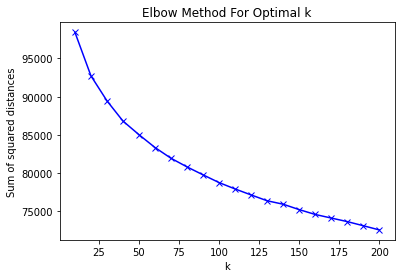

In [384]:
plot_kmeans(K,wvec_ssd,"elbow")

Plotting the silhouette score, with values closer to 1 indicating nicely separated clusters.

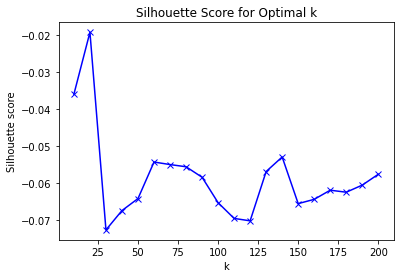

In [385]:
plot_kmeans(K,wvec_silhouette,"silhouette")

#### 2.5.2 T-SNE + Kmeans

As we saw above, using Kmeans on the raw embeddings did not produce very satisfactory results. To get clusters that are better separated, we will try to first reduce the vectors into two dimensions using the t-SNE algorithm, and then running Kmeans on these reduced embeddings.

In [57]:
method='barnes_hut'
n_components = 2
verbose = 1

In [58]:
E_tsne = TSNE(n_components=n_components, method=method, verbose=verbose).fit_transform(E)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 19498 samples in 0.004s...
[t-SNE] Computed neighbors for 19498 samples in 8.943s...
[t-SNE] Computed conditional probabilities for sample 1000 / 19498
[t-SNE] Computed conditional probabilities for sample 2000 / 19498
[t-SNE] Computed conditional probabilities for sample 3000 / 19498
[t-SNE] Computed conditional probabilities for sample 4000 / 19498
[t-SNE] Computed conditional probabilities for sample 5000 / 19498
[t-SNE] Computed conditional probabilities for sample 6000 / 19498
[t-SNE] Computed conditional probabilities for sample 7000 / 19498
[t-SNE] Computed conditional probabilities for sample 8000 / 19498
[t-SNE] Computed conditional probabilities for sample 9000 / 19498
[t-SNE] Computed conditional probabilities for sample 10000 / 19498
[t-SNE] Computed conditional probabilities for sample 11000 / 19498
[t-SNE] Computed conditional probabilities for sample 12000 / 19498
[t-SNE] Computed conditional probabilities for sam

A scatterplot of the reduced vectors indicates that there are indeed quite clear (albeit very many) clusters in the data.

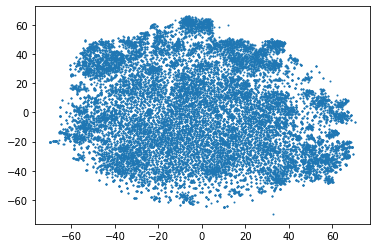

In [59]:
plt.scatter(E_tsne[:, 0], E_tsne[:, 1], s=1);

Run the same diagnostics as above, using the silhouette score and the elbow plot.

In [389]:
%%time

tsne_ssd, tsne_silhouette = kmeans_search(E_tsne, K)

For n_clusters = 10 The average silhouette_score is : 0.37478644
For n_clusters = 20 The average silhouette_score is : 0.36666763
For n_clusters = 30 The average silhouette_score is : 0.36414522
For n_clusters = 40 The average silhouette_score is : 0.35804102
For n_clusters = 50 The average silhouette_score is : 0.36096376
For n_clusters = 60 The average silhouette_score is : 0.3575868
For n_clusters = 70 The average silhouette_score is : 0.35891905
For n_clusters = 80 The average silhouette_score is : 0.36087665
For n_clusters = 90 The average silhouette_score is : 0.36161482
For n_clusters = 100 The average silhouette_score is : 0.3613771
For n_clusters = 110 The average silhouette_score is : 0.36354688
For n_clusters = 120 The average silhouette_score is : 0.36354893
For n_clusters = 130 The average silhouette_score is : 0.36461017
For n_clusters = 140 The average silhouette_score is : 0.365778
For n_clusters = 150 The average silhouette_score is : 0.36173385
For n_clusters = 160 Th

Elbow plot is much clearer than above, with a break at 20 or 25, or alternatively closer to 100.

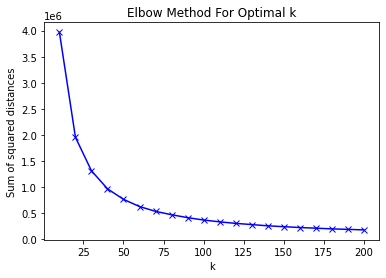

In [390]:
plot_kmeans(K,tsne_ssd,"elbow")

The silhouette score indicates that results are better than above, but the differences in values are quite nominal.

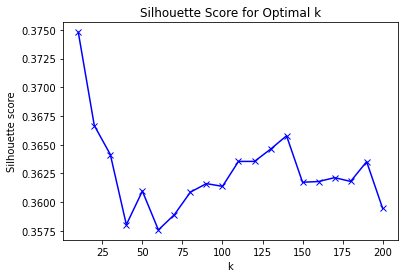

In [391]:
plot_kmeans(K,tsne_silhouette,"silhouette")

#### 2.5.3 PCA + Kmeans

While t-SNE gave us promising diagnostics, another approach would be to use dimensionality reduction with PCA. However, as can be seen inspecting the diagnostics below, PCA reduced vectors are actually much less clearly separated than the t-SNE reduced vectors. 

In [60]:
n_components = 0.9
verbose = 1

In [61]:
pca_fit = PCA(n_components = n_components).fit(E)

In [62]:
print(len(pca_fit.explained_variance_ratio_))
print(pca_fit.explained_variance_ratio_)
print(np.sum(pca_fit.explained_variance_ratio_))

179
[0.09085786 0.04430506 0.03889802 0.03021837 0.02840263 0.02468055
 0.02224194 0.02052893 0.01921241 0.01784137 0.01683477 0.0148225
 0.01361957 0.01283089 0.01258834 0.01158361 0.01097102 0.01016251
 0.0097819  0.00954368 0.00887937 0.00867909 0.00824066 0.00811348
 0.00771921 0.00730779 0.00714592 0.00705249 0.00681285 0.00655042
 0.00636943 0.00622913 0.00610005 0.00592973 0.00575623 0.00562367
 0.00544014 0.00528517 0.00526524 0.00500746 0.0049221  0.00485796
 0.00484005 0.00476447 0.00458024 0.00453214 0.00438317 0.00435277
 0.00416083 0.00410721 0.00400743 0.00394602 0.00391809 0.00383531
 0.00373255 0.0036343  0.00354919 0.00349796 0.00343568 0.0033994
 0.0033862  0.00331953 0.00327547 0.00321532 0.00318813 0.00315867
 0.003119   0.00305727 0.00301948 0.00298445 0.00293655 0.00291594
 0.00284899 0.00283848 0.00277709 0.00273183 0.00271985 0.00268629
 0.00266973 0.00262688 0.00256858 0.00254215 0.00252468 0.00250248
 0.00245366 0.00241552 0.00238988 0.00238026 0.00234211 0.00

In [63]:
E_pca = pca_fit.transform(E)

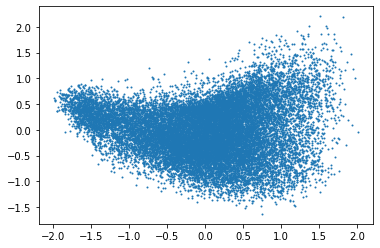

In [64]:
plt.scatter(E_pca[:, 0], E_pca[:, 1], s=1);

In [397]:
%%time

pca_ssd, pca_silhouette = kmeans_search(E_pca, K)

For n_clusters = 10 The average silhouette_score is : -0.022082698
For n_clusters = 20 The average silhouette_score is : -0.004242049
For n_clusters = 30 The average silhouette_score is : -0.04832848
For n_clusters = 40 The average silhouette_score is : -0.042334124
For n_clusters = 50 The average silhouette_score is : -0.04541711
For n_clusters = 60 The average silhouette_score is : -0.029091742
For n_clusters = 70 The average silhouette_score is : -0.04208782
For n_clusters = 80 The average silhouette_score is : -0.033878442
For n_clusters = 90 The average silhouette_score is : -0.039335344
For n_clusters = 100 The average silhouette_score is : -0.03747511
For n_clusters = 110 The average silhouette_score is : -0.04942073
For n_clusters = 120 The average silhouette_score is : -0.04341687
For n_clusters = 130 The average silhouette_score is : -0.041762803
For n_clusters = 140 The average silhouette_score is : -0.03971628
For n_clusters = 150 The average silhouette_score is : -0.038378

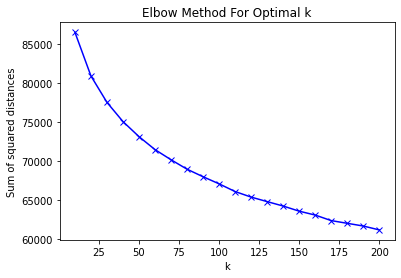

In [398]:
plot_kmeans(K,pca_ssd,"elbow")

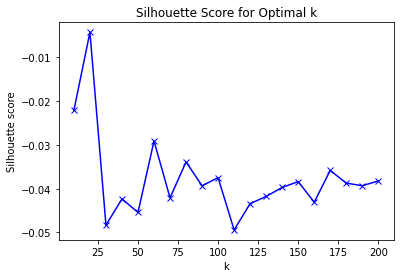

In [399]:
plot_kmeans(K,pca_silhouette,"silhouette")

#### 2.5.4 UMAP + Kmeans

Finally, we also try the increasingly popular UMAP dimensionality reduction technique. The results are comparible to the t-SNE reduced vectors, but because t-SNE is better known, we stick with that algorithm. However, UMAP could be a good alternative to explore in more detail in the future.

In [65]:
%%time

metric = 'cosine'
dm = cdist(E, E, metric)
np.fill_diagonal(dm, 0)

CPU times: user 2min 11s, sys: 2.02 s, total: 2min 13s
Wall time: 2min 14s


In [66]:
is_valid_dm(dm)

True

In [67]:
mean, std = np.mean(dm), np.std(dm)
print(mean, std)

0.5925560692136862 0.14890877456877802


In [68]:
min_dist=mean - 2*std
n_neighbors = int(0.001*len(E))
n_components=2
print(f"Min distance: {min_dist}")
print(f"N. neighbors: {n_neighbors}")
print(f"N. compontents: {n_components}")

Min distance: 0.29473852007613016
N. neighbors: 19
N. compontents: 2


In [69]:
%%time

E_umap = umap.UMAP(
    n_neighbors=n_neighbors,
    min_dist=min_dist,
    n_components=n_components,
    random_state=42,
    verbose=verbose
).fit_transform(E)

UMAP(dens_frac=0.0, dens_lambda=0.0, min_dist=0.29473852007613016,
     n_neighbors=19, random_state=42, verbose=1)
Construct fuzzy simplicial set
Thu Sep 16 17:40:51 2021 Finding Nearest Neighbors
Thu Sep 16 17:40:51 2021 Building RP forest with 12 trees
Thu Sep 16 17:40:53 2021 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	 5  /  14
	Stopping threshold met -- exiting after 5 iterations
Thu Sep 16 17:41:03 2021 Finished Nearest Neighbor Search
Thu Sep 16 17:41:07 2021 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Thu Sep 16 17:41:21 2021 Finished embedding
CPU times: user 32.8 s, sys: 3.25 s, total: 36.1 s
Wall time: 30.3 s


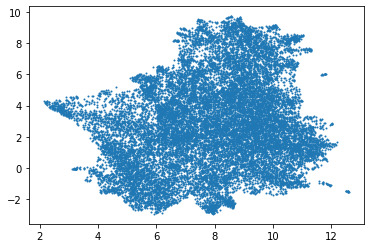

In [70]:
plt.scatter(E_umap[:, 0], E_umap[:, 1], s=1);

In [438]:
%%time

umap_ssd, umap_silhouette = kmeans_search(E_umap, K)

For n_clusters = 10 The average silhouette_score is : 0.351182
For n_clusters = 20 The average silhouette_score is : 0.35603577
For n_clusters = 30 The average silhouette_score is : 0.36309338
For n_clusters = 40 The average silhouette_score is : 0.35398746
For n_clusters = 50 The average silhouette_score is : 0.34627366
For n_clusters = 60 The average silhouette_score is : 0.34752306
For n_clusters = 70 The average silhouette_score is : 0.3474978
For n_clusters = 80 The average silhouette_score is : 0.34946468
For n_clusters = 90 The average silhouette_score is : 0.35045117
For n_clusters = 100 The average silhouette_score is : 0.34772164
For n_clusters = 110 The average silhouette_score is : 0.3505882
For n_clusters = 120 The average silhouette_score is : 0.3454415
For n_clusters = 130 The average silhouette_score is : 0.34700733
For n_clusters = 140 The average silhouette_score is : 0.34971148
For n_clusters = 150 The average silhouette_score is : 0.3476493
For n_clusters = 160 The 

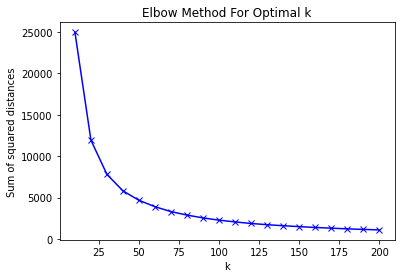

In [439]:
plot_kmeans(K,umap_ssd,"elbow")

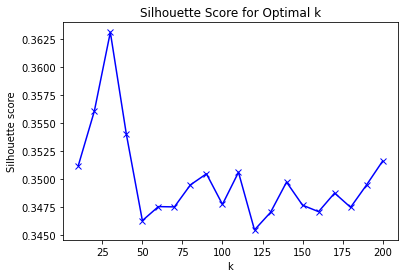

In [440]:
plot_kmeans(K,umap_silhouette,"silhouette")

#### 2.5.5 Choose clustering model

In [71]:
k_base = 100
k_pca = k_base
k_tsne = k_base
k_umap = k_base

In [72]:
%%time

km_base = cluster.KMeans(n_clusters=k_base,max_iter=300).fit(E)
labels = km_base.labels_
centroids = km_base.cluster_centers_

km_pca = cluster.KMeans(n_clusters=k_pca,max_iter=300).fit(E_pca)
labels_pca = km_pca.labels_

km_tsne = cluster.KMeans(n_clusters=k_tsne,max_iter=300).fit(E_tsne)
labels_tsne = km_tsne.labels_

km_umap = cluster.KMeans(n_clusters=k_umap,max_iter=300).fit(E_umap)
labels_umap=km_umap.labels_

CPU times: user 3min 20s, sys: 22.8 s, total: 3min 43s
Wall time: 48.8 s


Create an index that maps each word to a cluster.

In [73]:
word2cluster = {features[idx]: cl for idx, cl in enumerate(labels)}

In [74]:
print(take(10, word2cluster.items()))

[('[', 9), (']', 93), ('^', 9), ('_____', 9), ('aa_bowl', 5), ('aaaaaand', 85), ('aaron', 21), ('aarp', 10), ('abandoned', 27), ('abandoning', 19)]


Now, conversely, create an index that maps each cluster to a word.

In [75]:
cluster2words = defaultdict(list)
for key, value in word2cluster.items():
    cluster2words[value].append(key)

In [76]:
print(len(cluster2words[0]))
print(cluster2words[0][:100])

1563
['abo', 'aboutso', 'abovereferenced', 'abutment', 'accidentally_stepped', 'accomplish_feat', 'acknowledgment_presence', 'acutely', 'adah', 'aderall', 'adhere_covid', 'adinah', 'adipose', 'administratively', 'adventist_hospital', 'afer', 'african_accent', 'africanaccented', 'africanamerican_man', 'afterglo', 'afterthefact', 'ahlee', 'aight_run', 'aim_provide', 'airbrushed', 'aire', 'akiscia', 'al_vino', 'alderman', 'alecky', 'alfreado', 'alieracare', 'alieratrinity', 'allergenic', 'allergiesdietary', 'alzheimers', 'americanlike', 'amid_covid', 'amma', 'amniotic_fluid', 'amphetamine', 'anand', 'anaphylactic', 'anastacia', 'andina_toro_bravo', 'anesthetizing', 'anker', 'anniversaryit', 'anniverssary', 'annual_mammogram', 'annual_pap', 'antiscience', 'anual', 'anxiety_provoking', 'anxious_scared', 'aos', 'aplogized', 'apoplectic', 'applied_deductible', 'applying_lotion', 'apprising', 'approachability', 'apricothabanero', 'aqua_terra', 'arianne', 'armhand_massage', 'armshoulder', 'arro

In [77]:
print(len(cluster2words[1]))
print(cluster2words[1][:100])

59
['ahi', 'albacore', 'bento', 'bento_box', 'california_roll', 'caterpillar_roll', 'conveyor_belt_sushi', 'edamame', 'eel', 'eel_sauce', 'fish', 'gyoza', 'handrolls', 'hibachi', 'japanese', 'karaage', 'katsu', 'miso', 'miso_soup', 'monkey_brain', 'nigiri', 'nigiri_sashimi', 'omakase', 'onigiri', 'poke', 'poke_bowl', 'rainbow_roll', 'ramen', 'raw_fish', 'roe', 'roll', 'sake', 'sake_nigiri', 'salmon_roe', 'salmon_sashimi', 'sashimi', 'scallop_nigiri', 'seaweed_salad', 'shrimp_tempura', 'soft_shell', 'spicy_ahi', 'spicy_mayo', 'spicy_tuna', 'sushi', 'sushi_chef', 'sushi_roll', 'tempura', 'teriyaki', 'tomo', 'toro_fatty', 'tuna', 'tuna_nigiri', 'udon', 'unagi', 'uni', 'wasabi', 'yakitori', 'yellowtail', 'yuki']


### 2.6 Initialize documents

Transform all reviews into "documents", each with a set of weights per word in the corpus ("nbow"), the sum of these weights ("weights_sum"), the indeces of the words in the documents ("idxs") and the word vectors corresponding to each word ("vecs").

In [78]:
pos_nbow[0]

<1x19498 sparse matrix of type '<class 'numpy.float64'>'
	with 76 stored elements in Compressed Sparse Row format>

In [81]:
%%time 

pos_docs, neg_docs = [], []

for idx, doc in enumerate(pos_tok):
    pos_docs.append(Document(doc, pos_nbow[idx], word2idx, E))
    
for idx, doc in enumerate(neg_tok):
    neg_docs.append(Document(doc, neg_nbow[idx], word2idx, E))

CPU times: user 1.12 s, sys: 338 ms, total: 1.46 s
Wall time: 1.51 s


In [82]:
pos_docs[0].nbow

array([[0.00234907, 0.00234907, 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [83]:
pos_docs[0].weights_sum

1.0000000000000007

In [84]:
pos_docs[0].idxs[:10]

[0, 12928, 4864, 4995, 14976, 17409, 12416, 10626, 1, 4361]

In [85]:
pos_docs[0].vecs[:1][0][:10]

array([ 0.15857954, -0.15556984, -0.0054978 , -0.1308413 , -0.01429296,
       -0.12834749,  0.11757544,  0.13080046,  0.03922231,  0.3269623 ],
      dtype=float32)

### 2.7 Linear-Complexity Relaxed WMD (LC-RWMD)

Run the [Linear-Complexity Relaxed WMD](https://arxiv.org/abs/1711.07227) to get the distances between all positive and all negative reviews.

In [86]:
metric = "cosine"

In [155]:
lc_rwmd = LC_RWMD(pos_docs, neg_docs,pos_nbow,neg_nbow,E)

In [156]:
%time lc_rwmd.get_D(metric=metric)

CPU times: user 26min 22s, sys: 11min 28s, total: 37min 50s
Wall time: 10min 39s


### 2.8 Gale-Shapeley Pairing

Use the [Gale-Shapeley matching algorithm](https://en.wikipedia.org/wiki/Gale%E2%80%93Shapley_algorithm) to find the optimal pairs between positive and negative reviews. This iterates over all the reviews and finds the set of matches that pairs each review with its optimal match given that all positive reviews have to be matched with a negative review and vice versa. The output is a dictionary of key-value pairs, where each pair represents an optimal match.

In [264]:
# Options: 'gale_shapeley','random','full'

pairing = 'gale_shapeley'

In [284]:
%%time

if pairing == 'gale_shapeley':
    print("Running Gale-Shapeley pairing.")
    matcher = Matcher(lc_rwmd.D)
    engaged = matcher.matchmaker()
    print(f"Pairing is stable: {matcher.check()}")
    pairs = [(k, v) for k, v in engaged.items()]
if pairing == 'random':
    print("Running random pairing.")
    pos_idx = list(range(0,len(pos_docs)))
    neg_idx = list(range(0,len(neg_docs)))
    shuffle(pos_idx)
    shuffle(neg_idx)
    pairs = list(zip(pos_idx, neg_idx))
if pairing == 'full':
    print("Running full pairing.")
    pos_idx = list(range(0,len(pos_docs)))
    neg_idx = list(range(0,len(neg_docs)))
    pairs = [(i,j) for i in pos_idx for j in neg_idx]

Running Gale-Shapeley pairing.
Pairing is stable: True
CPU times: user 18.2 s, sys: 1.56 s, total: 19.7 s
Wall time: 21.5 s


Let's look at the output of Gale-Shapeley:

In [285]:
print(pairs[:20])

[(642, 315), (900, 897), (741, 300), (106, 100), (1290, 1413), (1438, 1841), (1461, 1002), (722, 808), (1572, 1004), (1814, 1738), (1696, 1886), (1478, 1989), (1496, 1318), (1491, 1009), (528, 333), (1724, 1421), (507, 408), (1142, 1012), (1295, 1651), (1867, 1580)]


In [286]:
example_pairs = [(' '.join(word for word in pos_docs[p[0]].words), 
                  ' '.join(word for word in neg_docs[p[1]].words))
                 for p in pairs]

In [319]:
example_pairs[1][0]

'[ made appointment treat carpal_tunnel pain twisting forearm knot treatment basically like miracle several month pain forearm returned ]'

In [320]:
example_pairs[1][1]

'[ describe horrible traumatizing_experience mocked kicked multiple time severe toxic_mold multiple life_threatening infection treated like hysterical woman lost everything due_illness would hire_lawyer vigorously pursue lawsuit ]'

In [289]:
len(pairs)

2000

### 2.9 Pairwise WMD with Baseline Kmeans

Calculate the pairwise distances between the documents selected by the Galey-Shapeley algorithm _without_ returning the flow between individual words.

In [313]:
%%time 

wmd_pairs = WMDPairs(pos_docs,neg_docs,pairs,E,idx2word, metric=metric)
wmd_pairs.get_distances(decompose=False,thread=False,relax=True)

Calculated distances between approximately 0 documents.00h00m00s elapsed.
Calculated distances between approximately 1000 documents.00h00m13s elapsed.
CPU times: user 17.3 s, sys: 7.94 s, total: 25.3 s
Wall time: 8.09 s


The return value is a matrix of distances between the document pairs.

In [314]:
np.max(wmd_pairs.distances)

0.5513135751961173

In [315]:
wmd_dists = np.concatenate(wmd_pairs.distances)
wmd_dists[wmd_dists != 0].mean()

0.3765172323626796

Calculate the pairwise distances between the documents selected by the Galey-Shapeley algorithm, this time also returning the flow between individual words.

In [309]:
%%time 

wmd_pairs_flow = WMDPairs(pos_docs,neg_docs,pairs,E,idx2word, metric=metric)
wmd_pairs_flow.get_distances(decompose = True, 
                             sum_clusters = True, 
                             w2c = word2cluster, 
                             c2w = cluster2words,
                             thread = False,
                             relax = True)

Calculated distances between approximately 0 documents.00h00m00s elapsed.
Calculated distances between approximately 1000 documents.00h00m17s elapsed.
CPU times: user 24.6 s, sys: 9.68 s, total: 34.3 s
Wall time: 10.5 s


Now we have three return values.

The first one is again a matrix of distances between the document pairs.

In [310]:
np.max(wmd_pairs_flow.distances)

0.5513135751961173

In [311]:
wmd_flow_dists = np.concatenate(wmd_pairs_flow.distances)
wmd_flow_dists[wmd_flow_dists != 0].mean()

0.3765172323626796

The second return value is a list of tuples with all the words that contributed the most to the distance from the positive documents to the negative ones. These are _not_ sorted from high to low or vice versa.

In [316]:
take(10, wmd_pairs_flow.wd_source.items())

[('birthday_celebration', 0.0226583601774986),
 ('expression_dental', 0.005637673584529411),
 ('skin_glow', 0.01012567361182255),
 ('eliteness', 0.0021306509996260495),
 ('pulled', 0.06859969769706639),
 ('infusion', 0.03401283582338302),
 ('fettuccine_alfredo', 0.006378264178395709),
 ('lucky_enough', 0.07621088830225972),
 ('brave', 0.010609518223180054),
 ('regard', 0.0028027647897746954)]

The third return value is a list of tuples with all the words that contributed the most to the distance from the negative documents to the positive ones. Again, these are _not_ sorted from high to low or vice versa.

In [104]:
take(10, wmd_pairs_flow.wd_sink.items())

[('birthday_celebration', 0.0229866639682548),
 ('suing', 0.01124885229511946),
 ('short_timeframe', 0.015740900792212808),
 ('niger', 0.00034696125634228736),
 ('expression_dental', 0.007441075504679906),
 ('supplying', 0.0036760124338224317),
 ('point_blank', 0.013270935005968518),
 ('forlorn', 0.01023144349614736),
 ('agreeing', 0.06197777184476137),
 ('hiddden', 0.0005607053953336381)]

In [105]:
take(10, wmd_pairs_flow.cd_source.items())

[(9, 9.546645389387406),
 (93, 7.288284006367971),
 (5, 4.3187305232742546),
 (85, 5.074789571941194),
 (21, 7.063542125178137),
 (10, 1.2103822256936605),
 (27, 9.17146737643573),
 (19, 1.6628359748172332),
 (45, 11.009789046838213),
 (51, 75.37801618113116)]

In [106]:
take(10, wmd_pairs_flow.cd_sink.items())

[(9, 15.606570280086899),
 (93, 4.101733423249725),
 (5, 2.102205632213395),
 (85, 3.2252011033749595),
 (21, 2.5990489022229086),
 (10, 8.172743867702973),
 (27, 12.296270444188616),
 (19, 6.164689309485116),
 (45, 1.6519722830701857),
 (51, 35.003698024515366)]

In [107]:
{k: v for k, v in sorted(wmd_pairs_flow.cd_source.items(), key=lambda item: item[1], reverse=True)[:10]}

{51: 75.37801618113116,
 52: 70.39405701427474,
 61: 31.082113443507847,
 24: 26.641863237643232,
 40: 23.895694193645667,
 90: 23.1674137038809,
 74: 21.9563180246418,
 68: 19.945118630207894,
 64: 16.429918521421506,
 43: 15.709078746193908}

In [108]:
wmd_pairs_flow.get_differences()

### 3.1 Intepreting pairwise WMD flows

Now, let's sort the distances of the words that created the most distance from the positive to the negative reviews.

In [116]:
top_words_source = {k: v for k, v in sorted(wmd_pairs_flow.wd_source_diff.items(), key=lambda item: item[1], reverse=True)[:30]}
top_words_source_df = pd.DataFrame.from_dict(top_words_source, orient='index', columns = ["distance"])
top_words_source_df['cost'] = top_words_source_df.distance.round(2)
top_words_source_df

,distance,cost
great,5.330140,5.33
best,4.495811,4.50
amazing,4.236421,4.24
love,3.752141,3.75
friendly,3.412612,3.41
delicious,3.168831,3.17
highly_recommend,3.054081,3.05
always,2.470556,2.47
favorite,2.444372,2.44
definitely,2.437642,2.44


Next, let's see what added most distance when moving from the negative to the positive reviews.

In [117]:
top_words_sink = {k: v for k, v in sorted(wmd_pairs_flow.wd_sink_diff.items(), key=lambda item: item[1], reverse=True)[:30]}
top_words_sink_df = pd.DataFrame.from_dict(top_words_sink, orient='index', columns = ["distance"])
top_words_sink_df['distance'] = top_words_sink_df.distance.round(2)
top_words_sink_df



,distance
never,2.68
told,2.50
order,2.40
rude,2.26
worst,2.18
minute,1.93
terrible,1.85
would,1.84
money,1.82
hour,1.80


Finally, let's look at the distances between the two sets by clustering similar words, in order to get a better sense of what kind of "topics" that separate them. Each cluster has a weight that matches the sum of the words belonging to that cluster. We choose *n* top clusters to inspect. To make the clusters interpretable, we also represent each of them by *m* keywords, selected based on the cost they individually add between the two sets.

In [118]:
n_clusters = 10
n_words = 10

In [120]:
c1 = output_clusters(wd=wmd_pairs_flow.wd_source_diff.items(), 
                     cd=wmd_pairs_flow.cd_source.items(), 
                     c2w=cluster2words, 
                     n_clusters=n_clusters, 
                     n_words=n_words)
c2 = output_clusters(wd=wmd_pairs_flow.wd_sink_diff.items(), 
                     cd=wmd_pairs_flow.cd_sink.items(), 
                     c2w=cluster2words, 
                     n_clusters=n_clusters, 
                     n_words=n_words)

Positive to negative clusters.

In [169]:
c1

,51,52,61,24,40,90,74,68,64,43
0,great (5.33),made (0.49),good (1.29),year (0.73),friendly (3.41),amazing (4.24),spot (1.19),delicious (3.17),fresh (1.19),focus (0.22)
1,best (4.5),able (0.42),nice (1.11),found (0.59),staff (2.37),excellent (1.97),place (1.13),favorite (2.44),tasty (0.73),self (0.13)
2,love (3.75),felt (0.4),really (1.08),glad (0.56),super (1.64),wonderful (1.69),town (0.89),loved (1.26),dish (0.53),careful (0.13)
3,highly_recommend (3.05),soon (0.38),kind (0.85),visit (0.46),helpful (0.98),perfect (1.27),food (0.84),try (0.79),hot (0.5),us (0.13)
4,always (2.47),coming (0.33),well (0.79),new (0.44),everyone (0.97),fantastic (1.22),lunch (0.43),must (0.77),bowl (0.33),becoming (0.11)
5,definitely (2.44),house (0.3),little (0.6),moved (0.42),attentive (0.89),incredible (0.77),gem (0.4),enjoyed (0.76),liked (0.26),control (0.1)
6,thank (1.55),next (0.21),lot (0.57),pleasantly_surprised (0.23),welcoming (0.63),outstanding (0.6),visiting (0.34),die (0.53),baked (0.21),improved (0.09)
7,awesome (1.51),come (0.16),enough (0.42),trip (0.22),accommodating (0.58),exceptional (0.43),miss (0.33),disappoint (0.32),shared (0.18),level (0.09)
8,everything (1.2),whole (0.15),much (0.38),st (0.18),pleasant (0.53),lovely (0.43),cart (0.27),heaven (0.31),large_portion (0.17),throughout (0.09)
9,happy (0.91),totally (0.15),especially (0.27),searching (0.18),personable (0.45),impressed (0.38),hidden_gem (0.25),yummy (0.3),homemade (0.17),immediate (0.08)


Negative to positive clusters.

In [122]:
c2 

,52,51,61,91,35,49,24,43,47,80
0,never (2.68),want (0.61),like (0.83),worst (2.18),told (2.5),order (2.4),went (0.9),use (0.6),called (1.68),rude (2.26)
1,would (1.84),go (0.53),hard (0.56),terrible (1.85),said (1.79),minute (1.93),closed (0.67),issue (0.44),call (1.49),customer (1.62)
2,u (1.4),return (0.42),maybe (0.52),money (1.82),asked (1.76),hour (1.8),drove (0.47),follow (0.38),appointment (1.06),unprofessional (0.86)
3,people (1.29),ever (0.39),however (0.42),horrible (1.59),manager (1.43),waiting (1.26),day (0.37),problem (0.32),phone (1.04),attitude (0.85)
4,even (1.2),need (0.33),fine (0.39),awful (1.17),refused (0.58),waited (0.94),month (0.28),understand (0.27),response (0.64),extremely_rude (0.43)
5,could (1.12),treat (0.22),lack (0.36),poor (1.16),ask (0.54),min (0.83),month_ago (0.28),due (0.23),answer_phone (0.63),embarrassed (0.26)
6,another (1.07),anyone (0.19),least (0.35),waste_time (0.88),received (0.49),pm (0.64),last (0.27),power (0.2),calling (0.48),act (0.26)
7,nothing (1.02),whether (0.14),think (0.26),unless (0.61),sent (0.47),line (0.5),decided (0.26),change (0.19),hung (0.4),incompetent (0.25)
8,left (0.94),advise (0.1),reason (0.26),worse (0.61),send (0.43),arrived (0.47),since (0.24),extreme (0.17),answer (0.39),rude_unprofessional (0.23)
9,give (0.9),seek (0.1),either (0.26),avoid (0.58),asking (0.37),delivery (0.42),twice (0.2),using (0.17),cancel (0.36),racist (0.23)


In [171]:
sample.shape

(4000, 20)

In [172]:
source_dists = pd.DataFrame(wmd_pairs_flow.source_feat)
source_dists.index = [p[0] for p in pairs]
source_dists = source_dists.sort_index()
source_dists = source_dists[c1.columns]
source_dists['categories'] = sample[:2000].categories

In [173]:
Counter(source_dists.categories)

Counter({'Health & Medical': 1000, 'Restaurants': 1000})

In [174]:
source_dists_long = pd.melt(source_dists, id_vars=['categories']).rename(columns={"variable":"cluster"})
source_dists_long.head()

,categories,cluster,value
0,Health & Medical,51,0.003333
1,Health & Medical,51,0.003410
2,Health & Medical,51,0.000000
3,Health & Medical,51,0.003941
4,Health & Medical,51,0.016813


In [175]:
source_dists_long = source_dists_long[source_dists_long.value != 0]

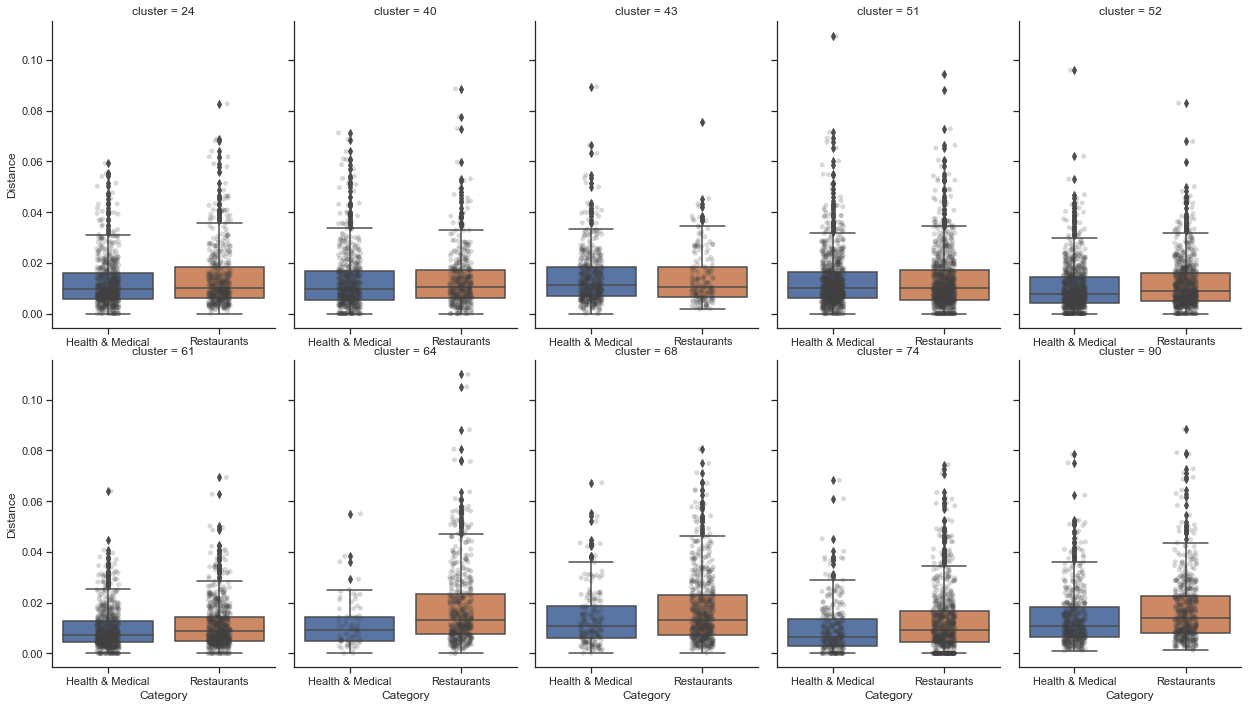

In [176]:
g = sns.catplot(x="categories", 
                y="value", 
                col="cluster", 
                data=source_dists_long, 
                kind="box",
                height=5, 
                aspect=.7,
                col_wrap=5,
                margin_titles=True);
g.map_dataframe(sns.stripplot, 
                x="categories", 
                y="value", 
                palette=["#404040"], 
                alpha=0.2, dodge=True)
g.set_axis_labels("Category", "Distance")
for ax in g.axes.flatten():
    ax.tick_params(labelbottom=True)


In [161]:
type(g)

seaborn.axisgrid.FacetGrid

In [129]:
sink_dists = pd.DataFrame(wmd_pairs_flow.sink_feat)
sink_dists.index = [p[1] for p in pairs]
sink_dists = sink_dists.sort_index()
sink_dists = sink_dists[c2.columns]
sink_dists['categories'] = sample[2000:4000].categories.tolist()

In [130]:
sink_dists_long = pd.melt(sink_dists, id_vars=['categories']).rename(columns={"variable":"cluster"})
sink_dists_long.head()

,categories,cluster,value
0,Health & Medical,52,2.464291e-02
1,Health & Medical,52,1.395675e-02
2,Health & Medical,52,1.309505e-03
3,Health & Medical,52,0.000000e+00
4,Health & Medical,52,2.143598e-09


In [131]:
sink_dists_long = sink_dists_long[sink_dists_long.value != 0]

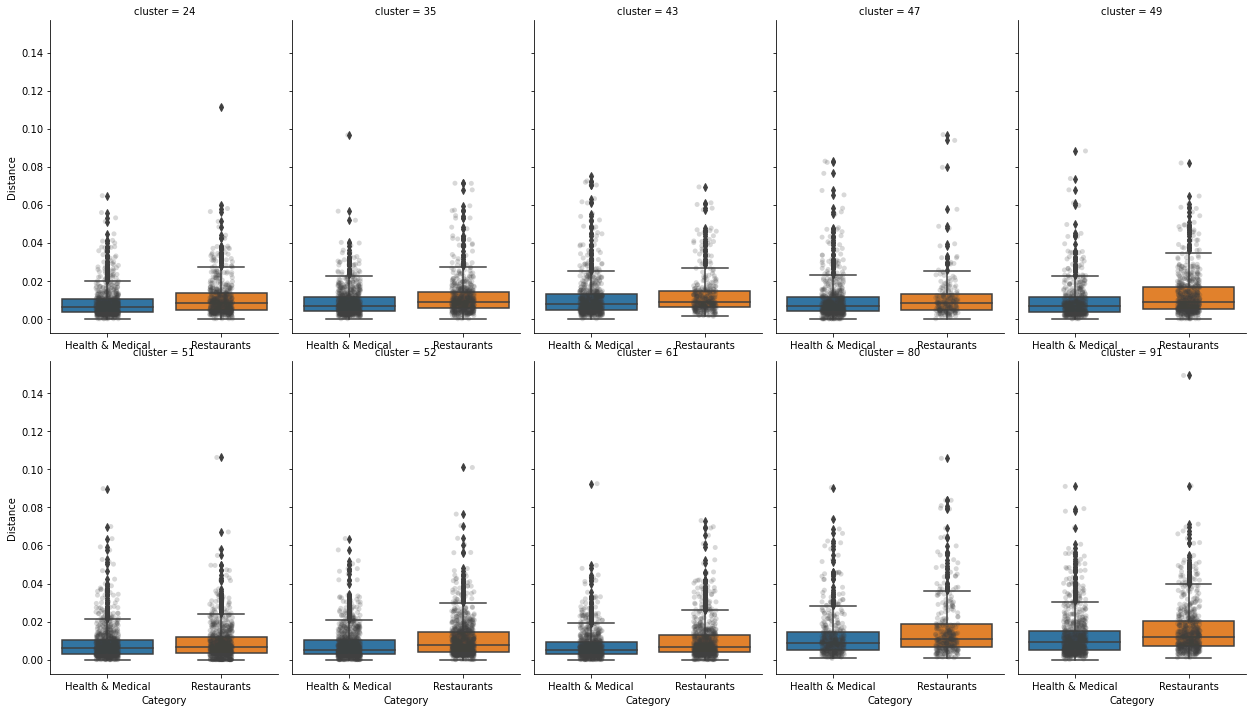

In [132]:
g = sns.catplot(x="categories", 
                y="value", 
                col="cluster", 
                data=sink_dists_long, 
                kind="box",
                height=5, 
                aspect=.7,
                col_wrap=5,
                margin_titles=True);
g.map_dataframe(sns.stripplot, 
                x="categories", 
                y="value", 
                palette=["#404040"], 
                alpha=0.2, dodge=True)
g.set_axis_labels("Category", "Distance")
for ax in g.axes.flatten():
    ax.tick_params(labelbottom=True)


## 4 Better clusters with UMAP and T-SNE

#### 4.1 UMAP + Kmeans

In [133]:
word2cluster_u = {features[idx]: cl for idx, cl in enumerate(labels_umap)}

In [134]:
print(take(10, word2cluster_u.items()))

[('[', 1), (']', 85), ('^', 43), ('_____', 43), ('aa_bowl', 99), ('aaaaaand', 1), ('aaron', 83), ('aarp', 98), ('abandoned', 97), ('abandoning', 75)]


Now, conversely, create an index that maps each cluster to a word.

In [135]:
cluster2words_u = defaultdict(list)
for key, value in word2cluster_u.items():
    cluster2words_u[value].append(key)

In [137]:
%%time 

wmd_pairs_flow_u = WMDPairs(pos_docs,neg_docs,pairs,E,idx2word)
wmd_pairs_flow_u.get_distances(decompose = True, 
                               sum_clusters = True, 
                               w2c = word2cluster_u, 
                               c2w = cluster2words_u,
                               thread = False,
                               relax = True)

Calculated distances between approximately 0 documents.00h00m00s elapsed.
Calculated distances between approximately 1000 documents.00h00m10s elapsed.
CPU times: user 18.3 s, sys: 1.91 s, total: 20.2 s
Wall time: 5.11 s


In [138]:
wmd_pairs_flow_u.get_differences()

In [139]:
c1_u = output_clusters(wd=wmd_pairs_flow_u.wd_source_diff.items(), 
                       cd=wmd_pairs_flow_u.cd_source.items(), 
                       c2w=cluster2words_u, 
                       n_clusters=n_clusters, 
                       n_words=n_words)
c2_u = output_clusters(wd=wmd_pairs_flow_u.wd_sink_diff.items(), 
                       cd=wmd_pairs_flow_u.cd_sink.items(), 
                       c2w=cluster2words_u, 
                       n_clusters=n_clusters, 
                       n_words=n_words)

In [140]:
c1_u

,93,85,17,40,60,27,73,70,42,10
0,definitely (2.44),amazing (4.24),great (5.33),always (2.47),every (0.82),everyone (0.97),recommend (0.83),friendly (3.41),spot (1.19),made (0.49)
1,nice (1.11),love (3.75),best (4.5),everything (1.2),soon (0.38),price (0.32),highly_suggest (0.13),helpful (0.98),place (1.13),nervous (0.41)
2,kind (0.85),excellent (1.97),selection (0.92),year (0.73),many (0.25),next (0.21),careful (0.13),team (0.97),town (0.89),thoroughly (0.18)
3,well (0.79),wonderful (1.69),happy (0.91),looking (0.5),highly (0.2),self (0.13),writing_review (0.1),attentive (0.89),food (0.84),seeing (0.16)
4,absolutely (0.69),awesome (1.51),try (0.79),look_forward (0.44),st (0.18),everybody (0.09),point (0.09),thanks (0.59),glad (0.56),continue (0.14)
5,lot (0.57),perfect (1.27),impressed (0.38),highly_recommended (0.41),future (0.17),somehow (0.09),hesitate (0.08),accommodating (0.58),lunch (0.43),express (0.13)
6,affordable (0.47),loved (1.26),variety (0.38),recommended (0.3),beyond (0.16),pricing (0.09),reccomend (0.05),helped (0.56),enjoy (0.28),exactly (0.09)
7,also (0.47),fantastic (1.22),top_notch (0.37),consistent (0.25),often (0.15),bringing (0.09),recommend_anyone (0.05),pleasant (0.53),joint (0.24),turning (0.09)
8,enough (0.42),incredible (0.77),miss (0.33),offer (0.22),first (0.12),reasonable (0.08),anyone_else (0.05),personable (0.45),stop (0.24),pace (0.08)
9,quality (0.41),enjoyed (0.76),pleased (0.3),truly (0.19),opportunity (0.12),gladly (0.08),recommending (0.04),friendly_helpful (0.42),secret (0.23),positive (0.07)


In [141]:
c2_u

,73,67,27,60,52,18,10,93,53,77
0,would (1.84),order (2.4),nothing (1.02),went (0.9),bad (1.35),never (2.68),people (1.29),like (0.83),money (1.82),told (2.5)
1,could (1.12),worst (2.18),star (0.78),looked (0.67),even (1.2),hour (1.8),time (0.67),return (0.42),customer (1.62),said (1.79)
2,another (1.07),minute (1.93),one (0.75),hard (0.56),get (0.82),left (0.94),wanted (0.55),ever (0.39),u (1.4),asked (1.76)
3,give (0.9),terrible (1.85),half (0.67),go (0.53),please (0.73),took (0.65),saw (0.39),yet (0.26),person (0.54),manager (1.43)
4,review (0.83),horrible (1.59),instead (0.67),going (0.44),two (0.61),take (0.65),hold (0.36),others (0.22),seated (0.47),refused (0.58)
5,still (0.82),waiting (1.26),anything (0.59),completely (0.34),avoid (0.58),tell (0.64),need (0.33),original (0.2),arrived (0.47),asking (0.37)
6,wrong (0.67),awful (1.17),maybe (0.52),way (0.3),dollar (0.54),someone (0.62),placed (0.29),stand (0.16),talking (0.45),stated (0.31)
7,want (0.61),poor (1.16),got (0.49),changed (0.29),somewhere_else (0.53),finally (0.56),turned (0.24),mind (0.12),sat (0.43),requested (0.27)
8,unless (0.61),ordered (1.07),unfortunately (0.46),seen (0.29),stay_away (0.4),empty (0.38),multiple (0.22),hoping (0.11),guy (0.41),embarrassed (0.26)
9,came (0.59),waited (0.94),literally (0.43),last (0.27),suck (0.39),leave (0.36),turn (0.2),bunch (0.11),paying (0.4),saying (0.25)


#### 4.1 T-SNE + Kmeans

In [142]:
word2cluster_t = {features[idx]: cl for idx, cl in enumerate(labels_tsne)}

In [143]:
print(take(10, word2cluster_t.items()))

[('[', 31), (']', 80), ('^', 31), ('_____', 31), ('aa_bowl', 1), ('aaaaaand', 31), ('aaron', 48), ('aarp', 87), ('abandoned', 91), ('abandoning', 61)]


Now, conversely, create an index that maps each cluster to a word.

In [144]:
cluster2words_t = defaultdict(list)
for key, value in word2cluster_t.items():
    cluster2words_t[value].append(key)

In [145]:
%%time 

wmd_pairs_flow_t = WMDPairs(pos_docs,neg_docs,pairs,E,idx2word)
wmd_pairs_flow_t.get_distances(decompose = True, 
                               sum_clusters = True, 
                               w2c = word2cluster_t, 
                               c2w = cluster2words_t,
                               thread = False,
                               relax = True)

Calculated distances between approximately 0 documents.00h00m00s elapsed.
Calculated distances between approximately 1000 documents.00h00m10s elapsed.
CPU times: user 18.9 s, sys: 2.17 s, total: 21.1 s
Wall time: 5.37 s


In [146]:
wmd_pairs_flow_t.get_differences()

In [149]:
c1_t = output_clusters(wd=wmd_pairs_flow_t.wd_source_diff.items(), 
                       cd=wmd_pairs_flow_t.cd_source.items(), 
                       c2w=cluster2words_t, 
                       n_clusters=n_clusters, 
                       n_words=n_words)
c2_t = output_clusters(wd=wmd_pairs_flow_t.wd_sink_diff.items(), 
                       cd=wmd_pairs_flow_t.cd_sink.items(), 
                       c2w=cluster2words_t, 
                       n_clusters=n_clusters, 
                       n_words=n_words)

In [150]:
c1_t

,98,26,86,80,7,16,11,54,94,22
0,best (4.5),great (5.33),always (2.47),love (3.75),miss (0.33),highly_recommend (3.05),good (1.29),super (1.64),friendly (3.41),professional (1.39)
1,definitely (2.44),amazing (4.24),everything (1.2),delicious (3.17),many (0.25),recommend (0.83),really (1.08),everyone (0.97),staff (2.37),team (0.97)
2,kind (0.85),excellent (1.97),every (0.82),favorite (2.44),next (0.21),looking (0.5),well (0.79),seeing (0.16),attentive (0.89),quick (0.86)
3,must (0.77),wonderful (1.69),year (0.73),perfect (1.27),first (0.12),made (0.49),little (0.6),whole (0.15),feel (0.82),fast (0.7)
4,option (0.38),awesome (1.51),absolutely (0.69),loved (1.26),turning (0.09),moved (0.42),also (0.47),totally (0.15),welcoming (0.63),helped (0.56)
5,coming (0.33),fantastic (1.22),new (0.44),enjoyed (0.76),bringing (0.09),soon (0.38),enough (0.42),self (0.13),accommodating (0.58),thorough (0.5)
6,world (0.3),beautiful (1.04),house (0.3),tasty (0.73),following (0.08),much (0.38),overall (0.3),express (0.13),pleasant (0.53),work (0.4)
7,beat (0.29),incredible (0.77),hand (0.29),die (0.53),handful (0.07),future (0.17),especially (0.27),skeptical (0.12),friendly_helpful (0.42),appreciate (0.4)
8,picky (0.28),outstanding (0.6),consistent (0.25),disappoint (0.32),million (0.06),continue (0.14),quite (0.21),eager (0.12),smile (0.42),efficient (0.34)
9,choice (0.27),exceptional (0.43),family_owned (0.21),heaven (0.31),accidentally (0.05),highly_suggest (0.13),along (0.18),extremely (0.11),felt (0.4),appreciated (0.32)


In [151]:
c2_t

,7,54,73,52,77,28,16,11,13,86
0,went (0.9),would (1.84),bad (1.35),never (2.68),worst (2.18),u (1.4),want (0.61),like (0.83),order (2.4),looked (0.67)
1,still (0.82),could (1.12),even (1.2),minute (1.93),terrible (1.85),pay (1.1),wanted (0.55),however (0.42),waiting (1.26),owner (0.47)
2,get (0.82),nothing (1.02),give (0.9),hour (1.8),horrible (1.59),paid (0.93),negative (0.34),actually (0.34),waited (0.94),look (0.36)
3,half (0.67),one (0.75),waste_time (0.88),another (1.07),awful (1.17),employee (0.65),know (0.3),yet (0.26),line (0.5),hold (0.36)
4,time (0.67),anything (0.59),please (0.73),min (0.83),poor (1.16),sitting (0.64),way (0.3),either (0.26),arrived (0.47),month_ago (0.28)
5,closed (0.67),maybe (0.52),wrong (0.67),slow (0.77),left (0.94),woman (0.61),changed (0.29),hate (0.2),delivery (0.42),walking (0.23)
6,came (0.59),saw (0.39),unless (0.61),someone (0.62),took (0.65),hostess (0.53),luck (0.26),original (0.2),seemed (0.38),ago (0.18)
7,run (0.5),completely (0.34),avoid (0.58),finally (0.56),take (0.65),server (0.51),since (0.24),decent (0.18),check (0.34),today (0.18)
8,got (0.49),seen (0.29),hard (0.56),longer (0.35),two (0.61),waitress (0.51),matter (0.21),stand (0.16),zero (0.33),temp (0.16)
9,getting (0.47),thought (0.28),somewhere_else (0.53),waited_minute (0.32),worse (0.61),seated (0.47),case (0.2),else (0.16),ordering (0.31),complete (0.12)


## 5 Reduced Dimension Inputs

### 5.1 UMAP

In [152]:
### TODO: lcwmd with UMAP

In [153]:
%%time 

wmd_pairs_flow_uvecs = WMDPairs(pos_docs,neg_docs,pairs,E_umap,idx2word)
wmd_pairs_flow_uvecs.get_distances(decompose = True, 
                                   sum_clusters = True, 
                                   w2c = word2cluster_u, 
                                   c2w = cluster2words_u,
                                   thread = True,
                                   relax = True)

Calculated distances between approximately 0 documents.00h00m00s elapsed.
Calculated distances between approximately 1000 documents.00h00m10s elapsed.
CPU times: user 18.5 s, sys: 7.56 s, total: 26.1 s
Wall time: 6.64 s


### 5.2 T-SNE